In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from fbprophet import Prophet
import seaborn as sns
%matplotlib inline

In [3]:
#Load the csv data, creating pandas dataframe by persisting date format
world_df = pd.read_csv('https://raw.githubusercontent.com/bitprj/covid19/master/covid_data.csv',parse_dates=['Date'])

In [4]:
#df.head() Returns the first 5 rows of the dataframe. To override the default, you may insert a value between the parenthesis to change the number of rows returned. Example: df.head(10) will return 10 rows.


In [5]:
#Display top 5 records
world_df.head(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [ ]:
"""
                Dataset Information
1.id - Serial Number
2.Province_State - Respective State of the Country
3.Country_Region - Country Name
4.Date - Date(yyyy-mm-dd) format
5.ConfirmedCases - Total cases till provided date(It's a cumilative number)
6.Fatalities - Total deaths till provided date(It's a cumilative number)
"""

In [7]:
#df.describe() - allows us to view some descriptive statistics that summarises the central tendancy, dispersion, and shape
#so what we want to do next is to view some basic statistical details like percentil, mean and std
world_df.describe()

,Id,ConfirmedCases,Fatalities
count,27231.000000,27231.000000,27231.000000
mean,17828.000000,1372.808050,75.991444
std,10300.673333,9488.242361,808.719059
min,1.000000,0.000000,0.000000
25%,8914.500000,0.000000,0.000000
50%,17828.000000,2.000000,0.000000
75%,26741.500000,138.000000,1.000000
max,35655.000000,230597.000000,22745.000000


In [8]:
#df.info()Provides a summary of the data including the index data type, column data types, non-null values and memory usage.
world_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
Id                27231 non-null int64
Province_State    11571 non-null object
Country_Region    27231 non-null object
Date              27231 non-null datetime64[ns]
ConfirmedCases    27231 non-null float64
Fatalities        27231 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [9]:
#Before we start data analysis, we have to determine if there are any anomalies with the data which is called QAing the Data

In [10]:
#Whether the data frame has any NaN values
world_df.isnull().values.any()

True

In [11]:
#whether the data frame has any NAN values
world_df.isnull().sum()

Id                    0
Province_State    15660
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [ ]:
""""
So only Province_State has 15660 NaN values. We are going to replace the NaN values with a blank string.""
""""

In [19]:
#Replace NAN values with blank string
world_df.fillna({'Province_State': ""},inplace=True)

In [ ]:
"""
            Data Visualization
Total world wide Covid-19 Cases and deaths representations
"""

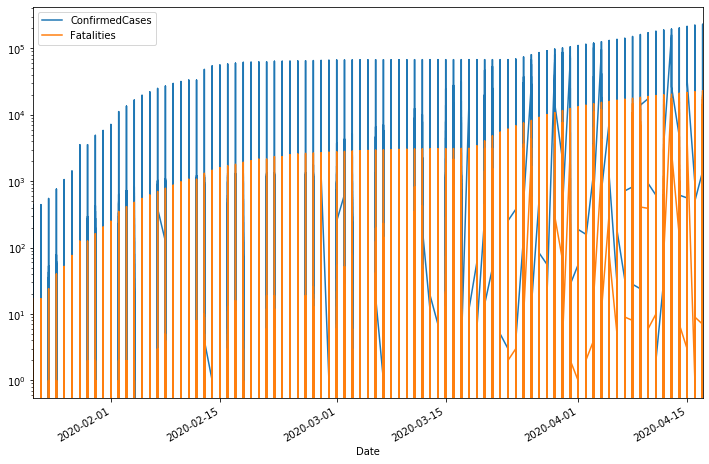

In [22]:
#bar chart for total confirmed and fatalities cases
axis = world_df[['Date','ConfirmedCases','Fatalities']].set_index('Date').plot(figsize=(12, 8),logy=True)
plt.show()

In [23]:
#Data Aggregation

world_df.groupby('Country_Region')
#world_df.groupby('Country_Region')['ConfirmedCases'].sum()
#world_df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()

In [27]:
country_cases_df = world_df.groupby('Country_Region')['ConfirmedCases'].sum().reset_index()
country_cases_df.sort_values(["ConfirmedCases"],ascending=False,inplace=True)

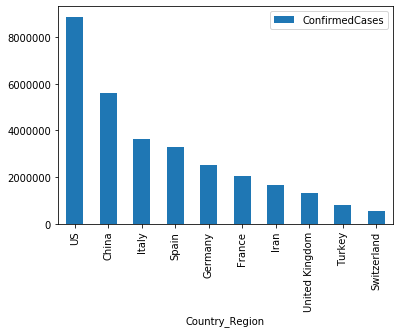

In [28]:
top_count = 10
country_cases_df[:top_count].plot.bar(x='Country_Region',y = 'ConfirmedCases');

In [29]:
#Q1: Most death rated counties?

#Find sum of deaths per country
country_death_df = world_df.groupby('Country_Region')['Fatalities'].sum().reset_index()

#merge grouped cases and grouped deaths
total_df = country_death_df.merge(country_cases_df)


#Find death rate and sort in descending order
total_df['DeathRate']   = (total_df.Fatalities / total_df.ConfirmedCases)*100
total_df.sort_values('DeathRate',ascending=False,inplace=True)

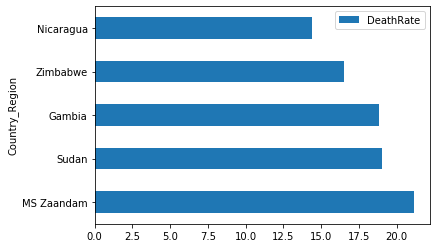

In [30]:
#Visualize

#bar chart with x = death rate and y = countries
axis = total_df.head(5).plot.barh(x='Country_Region',y = 'DeathRate');
plt.show()

In [ ]:
"""
Most death rated countries are displayed through bar chart. 
If notice most of them are economically poor countries. Their health care system would be very minimal.
"""

In [ ]:
"""

Train and Test data split
This functions prepare train test data split

Why train/test split? We don't have the future data we want to predict. However, we're able to access the performance of our model's ability to predict future data. So we hold out a portion of our working data as "test" data and only train the model on the leftover part, the "train" data.

Parameters

df (dataframe) : The dataframe to be processed
period (int) : Test dataset size(default is 5 days)
Returned Data

train_data (dataframe) - train set to train the model
test_data (dataframe) - test set to train the model
"""

In [32]:
def train_test_data_split(df,period=5):
  #Excluding last 5 for the training set
  train_data = df[:-period]
  #Including last 5 for the test set
  test_data =  df[-period:]
  return train_data,test_data

In [ ]:
"""
Prophet Model Training
Facebook's Prophet framework is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. The modeling function helps in build and deploy the model

Parameters

train_data (dataframe) - train set to train the model
Returned Data

pm (prophet object) -  prophet object to run the predictions
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:
"""

In [33]:
def modeling(train_data):
  #Prophet algorith helps to predict the time series data
  pm = Prophet(changepoint_prior_scale=0.95,interval_width=1)
  #training the model
  pm.fit(train_data)
  return pm

In [ ]:
"""
Predictions
This functions helps in run the predictions

Parameters

pm (prophet object) -  prophet object to run the predictions
periods(int) - Number of days for predictions
Returned Data

pm_forecast (dataframe) -  dataframe with predictions
"""

In [34]:
def predictions(pm,periods=5):
  #considering 5 future days
  future = pm.make_future_dataframe(periods)
  #predicting provided days
  pm_forecast = pm.predict(future)
  return pm_forecast

In [35]:
"""

Model Evaluation
The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a loss function for regression problems in machine learning. It usually expresses the accuracy as a ratio defined by the formula:

TL;DR - On average, how does the forecasted values deviate (percentage wise) from the actual values.

This functions helps to evaluate the model

Parameters
  y_true (dataframe) -  test dataset
  y_pred(dataframe) - predicted dataset
Returns:  
  mape (int) -  integer
"""

In [ ]:
#To calculate the deviation, we use numpy's .abs function to calculate the deviation of the true value from the prediction.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
"""
Helper Function
Main function which helps to run the data preparation,model execution, predictions and evaluations

Parameters

world_df (dataframe) - Dataframe which loaded through csv
countries (list) - comma seperated list of countries
"""

In [36]:
def helper(df,countries):

    # train/test split, fitting the model, and predicting (5) days ahead
    train_data,test_data = train_test_data_split(df,5)
    pm = modeling(train_data)
    predictions_df = predictions(pm,5)
    
    #finalizes resulting data frame output
    results_df = predictions_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test_data)
    print(results_df)
    
    #plots the historical data and predictions
    fig1 = pm.plot(predictions_df)
    fig1.suptitle(country,verticalalignment='center')
    fig2 = pm.plot_components(predictions_df)
    fig2.suptitle(country,verticalalignment='center')
    print(country+' MAPE: '+str(mean_absolute_percentage_error(results_df['yhat'].iloc[0], results_df['y'].iloc[0])))
    return results_df

In [ ]:
"""
                    Analysis
Q2. Predict Future Cases for a given country

This functions prepare data country wise for predictions

Parameters df (dataframe) : The dataframe to be processed country (str) : Should be valid county name Returns:
country_rn_df (dataframe) - Returns most country wise dataset
"""

In [37]:
def countryWiseCasesPredictions(df,country):
  
  #grouping country wise
  country_df = world_df.groupby(['Country_Region','Date'])[['ConfirmedCases','Fatalities']].sum().reset_index()
  #filtering provided country data
  country_df = country_df[country_df.Country_Region == country]
  #Renaming column to fit prophet's model 
  country_rn_df = country_df.rename(columns={"Date":"ds","ConfirmedCases":"y"})
  #Dropping unused columns
  country_rn_df = country_rn_df.reset_index().drop(["index","Fatalities","Country_Region"],axis= 1)
  return country_rn_df